In [1]:
import cv2
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import odc.stac
import pandas as pd
from pathlib import Path
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import rioxarray

%matplotlib inline

In [2]:
# Establish a connection to the STAC API
import planetary_computer as pc
from pystac_client import Client

catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1", modifier=pc.sign_inplace
)

In [3]:
metadata = pd.read_csv('../data/metadata.csv')

In [4]:
import geopy.distance as distance

In [5]:
# get our bounding box to search latitude and longitude coordinates
def get_bounding_box(latitude, longitude, meter_buffer=3000):
    """
    Given a latitude, longitude, and buffer in meters, returns a bounding
    box around the point with the buffer on the left, right, top, and bottom.

    Returns a list of [minx, miny, maxx, maxy]
    """
    distance_search = distance.distance(meters=meter_buffer)

    # calculate the lat/long bounds based on ground distance
    # bearings are cardinal directions to move (south, west, north, and east)
    min_lat = distance_search.destination((latitude, longitude), bearing=180)[0]
    min_long = distance_search.destination((latitude, longitude), bearing=270)[1]
    max_lat = distance_search.destination((latitude, longitude), bearing=0)[0]
    max_long = distance_search.destination((latitude, longitude), bearing=90)[1]

    return [min_long, min_lat, max_long, max_lat]

In [6]:
# get our date range to search, and format correctly for query
def get_date_range(date, time_buffer_days=15):
    """Get a date range to search for in the planetary computer based
    on a sample's date. The time range will include the sample date
    and time_buffer_days days prior

    Returns a string"""
    datetime_format = "%Y-%m-%d"
    range_start = pd.to_datetime(date) - timedelta(days=time_buffer_days)
    date_range = f"{range_start.strftime(datetime_format)}/{pd.to_datetime(date).strftime(datetime_format)}"

    return date_range

In [7]:
example_row = metadata[metadata.uid == "garm"].iloc[0]
example_row

uid                garm
latitude       41.98006
longitude    -110.65734
date         2021-09-27
split             train
Name: 5461, dtype: object

In [8]:
bbox = get_bounding_box(example_row.latitude, example_row.longitude, meter_buffer=3000)
bbox

[-110.69353838433213,
 41.953050646872555,
 -110.62114161566788,
 42.00706922560391]

In [9]:
date_range = get_date_range(example_row.date, 15)
date_range

'2021-09-12/2021-09-27'

In [10]:
# search the planetary computer sentinel-l2a and landsat level-2 collections
search = catalog.search(
    collections=["landsat-c2-l2"], bbox=bbox, datetime=date_range
)

# see how many items were returned
items = [item for item in search.item_collection()]
len(items)

4

In [11]:
# get details of all of the items returned
item_details = pd.DataFrame(
    [
        {
            "datetime": item.datetime.strftime("%Y-%m-%d"),
            "platform": item.properties["platform"],
            "min_long": item.bbox[0],
            "max_long": item.bbox[2],
            "min_lat": item.bbox[1],
            "max_lat": item.bbox[3],
            "bbox": item.bbox,
            "item_obj": item,
        }
        for item in items
    ]
)

# check which rows actually contain the sample location
item_details["contains_sample_point"] = (
    (item_details.min_lat < example_row.latitude)
    & (item_details.max_lat > example_row.latitude)
    & (item_details.min_long < example_row.longitude)
    & (item_details.max_long > example_row.longitude)
)

print(
    f"Filtering from {len(item_details)} returned to {item_details.contains_sample_point.sum()} items that contain the sample location"
)

item_details = item_details[item_details["contains_sample_point"]]
item_details[["datetime", "platform", "contains_sample_point", "bbox"]].sort_values(
    by="datetime"
)

Filtering from 4 returned to 4 items that contain the sample location


,datetime,platform,contains_sample_point,bbox
3,2021-09-12,landsat-8,True,"[-111.34023745, 40.67702495, -108.51528663, 42..."
2,2021-09-19,landsat-8,True,"[-112.92522743, 40.67353498, -110.06644659, 42..."
1,2021-09-20,landsat-7,True,"[-111.60018779, 40.80284495, -108.59831681, 42..."
0,2021-09-27,landsat-7,True,"[-113.18385774, 40.78803499, -110.15150674, 42..."


In [12]:
# 1 - filter to sentinel
item_details[item_details.platform.str.contains("landsat")]

,datetime,platform,min_long,max_long,min_lat,max_lat,bbox,item_obj,contains_sample_point
0,2021-09-27,landsat-7,-113.183858,-110.151507,40.788035,42.771725,"[-113.18385774, 40.78803499, -110.15150674, 42...",<Item id=LE07_L2SP_038031_20210927_02_T1>,True
1,2021-09-20,landsat-7,-111.600188,-108.598317,40.802845,42.754385,"[-111.60018779, 40.80284495, -108.59831681, 42...",<Item id=LE07_L2SP_037031_20210920_02_T1>,True
2,2021-09-19,landsat-8,-112.925227,-110.066447,40.673535,42.819695,"[-112.92522743, 40.67353498, -110.06644659, 42...",<Item id=LC08_L2SP_038031_20210919_02_T1>,True
3,2021-09-12,landsat-8,-111.340237,-108.515287,40.677025,42.817595,"[-111.34023745, 40.67702495, -108.51528663, 42...",<Item id=LC08_L2SP_037031_20210912_02_T1>,True


In [13]:
# 2 - take closest by date
best_item = (
    item_details[item_details.platform.str.contains("landsat")]
    .sort_values(by="datetime", ascending=False)
    .iloc[0]
)
best_item

datetime                                                        2021-09-27
platform                                                         landsat-7
min_long                                                       -113.183858
max_long                                                       -110.151507
min_lat                                                          40.788035
max_lat                                                          42.771725
bbox                     [-113.18385774, 40.78803499, -110.15150674, 42...
item_obj                         <Item id=LE07_L2SP_038031_20210927_02_T1>
contains_sample_point                                                 True
Name: 0, dtype: object

In [14]:
item = best_item.item_obj

In [15]:
# What assets are available?
for asset_key, asset in item.assets.items():
    print(f"{asset_key:<25} - {asset.title}")

qa                        - Surface Temperature Quality Assessment Band
ang                       - Angle Coefficients File
red                       - Red Band
blue                      - Blue Band
drad                      - Downwelled Radiance Band
emis                      - Emissivity Band
emsd                      - Emissivity Standard Deviation Band
lwir                      - Surface Temperature Band
trad                      - Thermal Radiance Band
urad                      - Upwelled Radiance Band
atran                     - Atmospheric Transmittance Band
cdist                     - Cloud Distance Band
green                     - Green Band
nir08                     - Near Infrared Band 0.8
swir16                    - Short-wave Infrared Band 1.6
swir22                    - Short-wave Infrared Band 2.2
mtl.txt                   - Product Metadata File (txt)
mtl.xml                   - Product Metadata File (xml)
cloud_qa                  - Cloud Quality Assessment Band
mtl.js

In [16]:
def crop_landsat_image(item, bounding_box):
    """
    Given a STAC item from Landsat and a bounding box tuple in the format
    (minx, miny, maxx, maxy), return a cropped portion of the item's visual
    imagery in the bounding box.

    Returns the image as a numpy array with dimensions (color band, height, width)
    """
    (minx, miny, maxx, maxy) = bounding_box

    image = odc.stac.stac_load(
        [pc.sign(item)], bands=["red", "green", "blue"], bbox=[minx, miny, maxx, maxy]
    ).isel(time=0)
    image_array = image[["red", "green", "blue"]].to_array().to_numpy()

    # normalize to 0 - 255 values
    image_array = cv2.normalize(image_array, None, 0, 255, cv2.NORM_MINMAX)

    return image_array

In [17]:
minx, miny, maxx, maxy = get_bounding_box(
    example_row.latitude, example_row.longitude, meter_buffer=3000
)

# get the zoomed in image array
bbox = (minx, miny, maxx, maxy)
img = crop_landsat_image(item, bbox)

In [18]:
img

array([[[164, 154, 158, ..., 149, 149, 149],
        [162, 158, 162, ..., 153, 149, 147],
        [160, 158, 156, ..., 153, 147, 145],
        ...,
        [160, 156, 156, ..., 151, 149, 149],
        [178, 176, 170, ..., 151, 147, 153],
        [193, 195, 172, ..., 149, 151, 153]],

       [[151, 147, 147, ..., 139, 141, 139],
        [151, 147, 147, ..., 143, 139, 137],
        [149, 145, 145, ..., 143, 141, 137],
        ...,
        [145, 147, 145, ..., 145, 141, 143],
        [160, 162, 152, ..., 141, 143, 143],
        [169, 169, 156, ..., 143, 143, 143]],

       [[136, 136, 136, ..., 131, 135, 133],
        [136, 136, 138, ..., 135, 133, 131],
        [138, 136, 134, ..., 135, 131, 129],
        ...,
        [137, 135, 137, ..., 133, 135, 135],
        [143, 147, 139, ..., 135, 135, 139],
        [147, 149, 141, ..., 137, 135, 137]]], dtype=uint16)

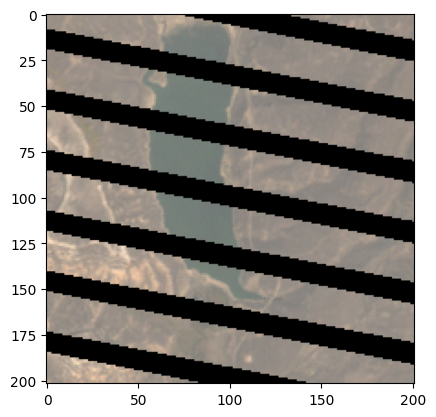

In [19]:
plt.imshow(np.transpose(img, axes=[1, 2, 0]))